# Imports and Getting Data

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('talk')
import sys
sys.path.append('fges-py')
print(sys.path)
from SEMScore import *
from fges import *
from SemEstimator import SemEstimator

['c:\\Users\\Justin Hong\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'c:\\Users\\Justin Hong\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\Justin Hong\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\Justin Hong\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\Justin Hong\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\Justin Hong\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\Justin Hong\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Justin Hong\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Users\\Justin Hong\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', 'fges-py', 'fges-py']


c:\Users\Justin Hong\OneDrive\Documents\CFL_Research\astro_pc_fges_test\fges-py\fges.py:501: SyntaxWarning: invalid escape sequence '\i'
  """ T is a subset of the neighbors of Y that are not adjacent to


In [20]:
filename = 'tetrad_galacticus_table_acyclic.dat'
data = np.loadtxt(filename, skiprows=1)
var_names = np.loadtxt(filename, max_rows=1, dtype=str)

> Data exploration done in test_pc.ipynb

In [21]:
# get correlation matrix for comparison later on
corr = np.corrcoef(data.T)
np.fill_diagonal(corr, 0)

# FGES Algorithm without Subsampling

In [22]:
def infer_edges(data, s=8):
    '''
    Arguments:
        data : an n_samples x n_nodes array
        s : sparsity parameter for FGES (default = 8 as was used in Dubois et al.)
    Returns:
        edges : a list of tuples, where each tuple (i,j) represents an edge 
                found between node i and node j
        fges_result : dict of results from fges.search() (needed for estimating
                      the correlation matrix later on)
    '''

    # FGES takes a score function that depends on the data and a user-determined
    # sparsity level (penalty discount)
    score = SEMBicScore(penalty_discount=s, dataset=data)

    # run FGES
    fges = FGES(range(data.shape[1]), score, filename=data)
    fges_result = fges.search()
    edges = fges_result['graph'].edges()
    return edges, fges_result

def fges_edges_to_mat(edges, n_nodes):
    adj_mat = np.zeros((n_nodes, n_nodes))
    for i, j in edges:
        adj_mat[i, j] = 1
        adj_mat[j, i] = 1
    return adj_mat

edges, fges_result = infer_edges(data)
adj_mat = fges_edges_to_mat(edges, data.shape[1])

> Note: Sparsity parameter (s) is the same as complexity parameter, defualted to 8

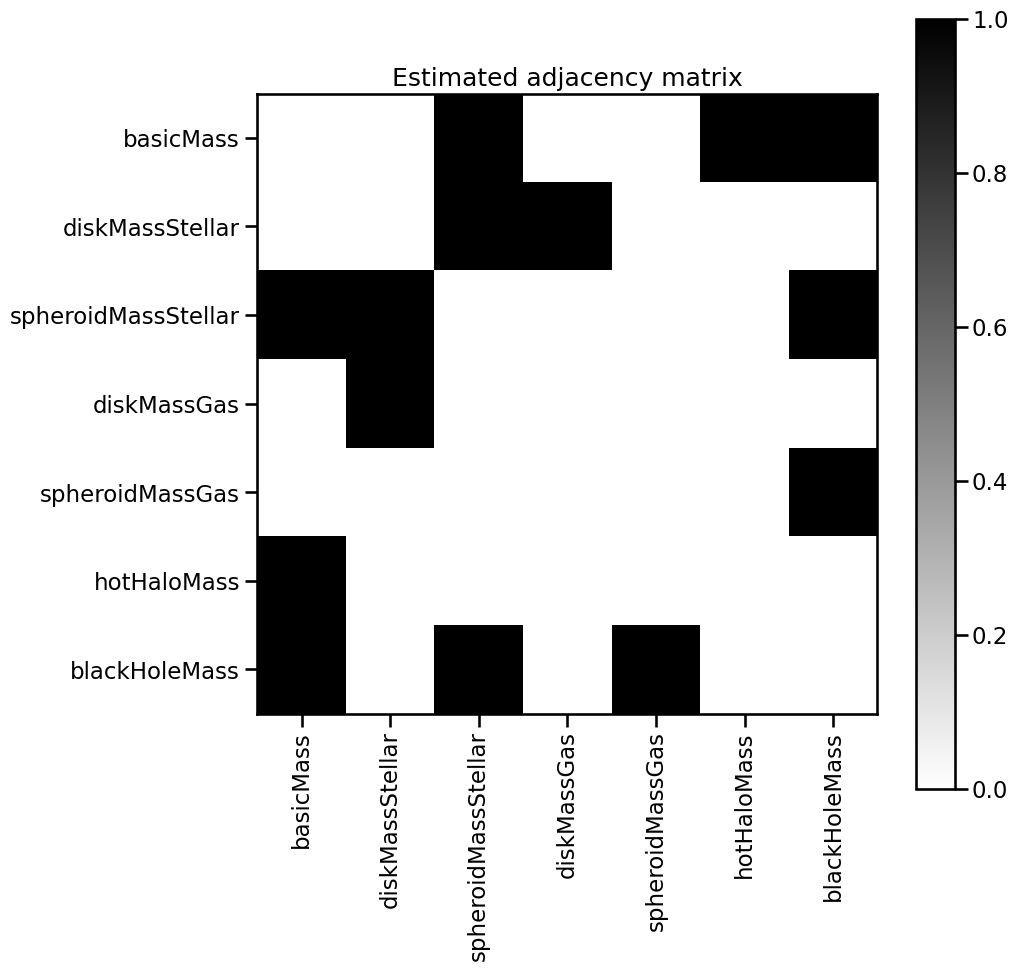

In [23]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(adj_mat, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.xticks(range(data.shape[1]), var_names, rotation=90)
plt.yticks(range(data.shape[1]), var_names)
plt.title('Estimated adjacency matrix')
plt.show()

In [24]:
def estimate_corr(data, fges_result):
    '''
    Arguments:
        data : an n_samples x n_nodes numpy array
        fges_result : a dict of results returned by fges.search()
    Returns:
        est_corr : an n_nodes x n_nodes numpy array estimated correlation matrix
    '''
    sem_est = SemEstimator(data, sparsity=4)

    # provide to the estimator the DAG found above
    sem_est.pattern = fges_result['graph']

    # estimate the weights and residuals
    sem_est.estimate()

    # get covariance matrix from SemEstimator
    est_cov = sem_est.graph_cov

    # compute correlation matrix from covariance matrix
    stdistdj = np.sqrt(np.diag(est_cov))
    est_corr = est_cov / np.outer(stdistdj, stdistdj)
    return est_corr

est_corr = estimate_corr(data, fges_result)
np.fill_diagonal(est_corr, 0)

c:\Users\Justin Hong\OneDrive\Documents\CFL_Research\test_data\fges-py\search_util.py:172: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  params, r, _, _ = np.linalg.lstsq(a, b)


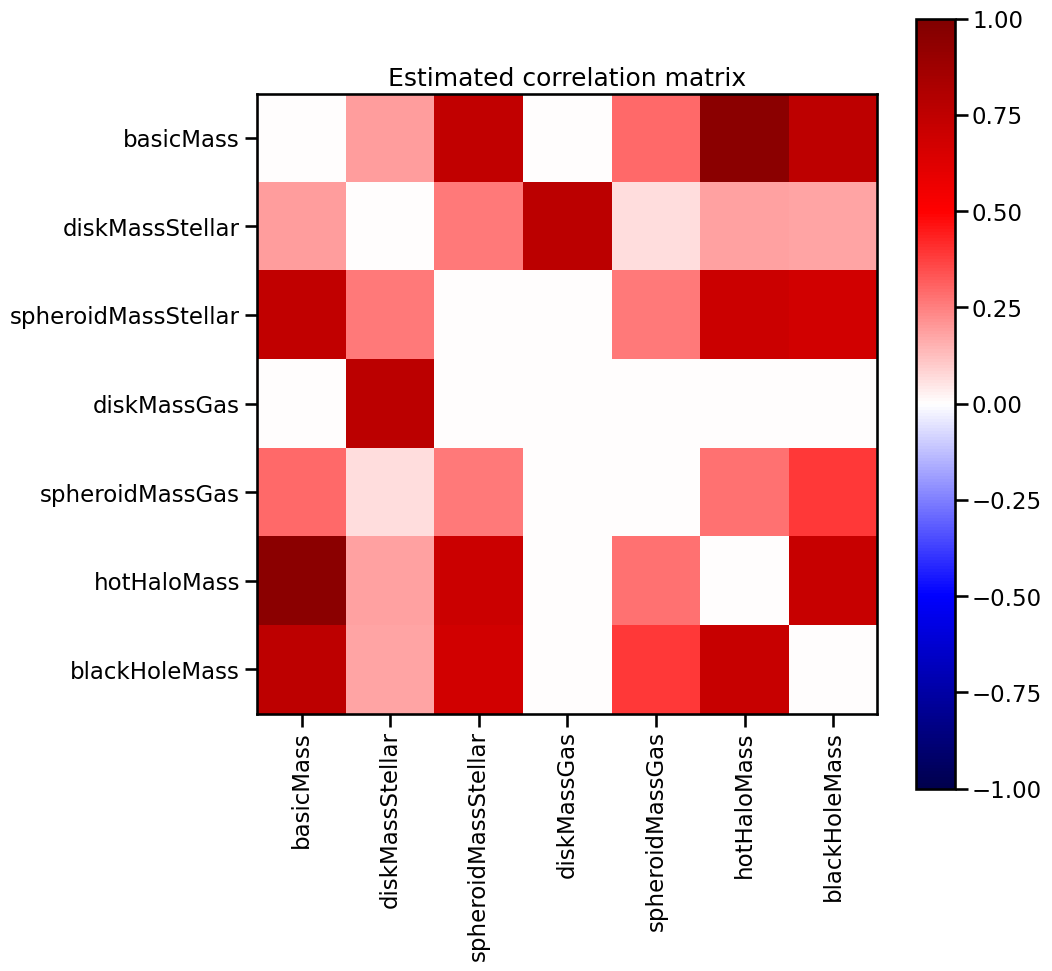

In [25]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(est_corr, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
plt.xticks(range(data.shape[1]), var_names, rotation=90)
plt.yticks(range(data.shape[1]), var_names)
plt.title('Estimated correlation matrix')
plt.show()

In [26]:
# compare with true correlation matrix
true_vec = corr[np.tril_indices(corr.shape[0], k=-1)].flatten()
est_vec = est_corr[np.tril_indices(est_corr.shape[0], k=-1)].flatten()
print(np.corrcoef(true_vec, est_vec)[0,1])

0.9758032382375551


# FGES Algorithm with Subsampling

In [27]:
# 4 subsamples with 365 samples each - SEEDED TESTS w/ 42

np.random.seed(42)
n_samples = 365

def subsample_data(data, n_samples):
    idxs = np.arange(data.shape[0])
    np.random.shuffle(idxs)
    
    assert data.shape[0] % n_samples == 0, "length of data needs to be divisible by samples"
    subsample_idxs = np.array_split(idxs, data.shape[0] // n_samples)
    return [data[idxs] for idxs in subsample_idxs]

subsamples = subsample_data(data, n_samples)

# run FGES on each subsample
adj_mats = []
for subsample in subsamples:
    edges, fges_result = infer_edges(subsample)
    adj_mats.append(fges_edges_to_mat(edges, data.shape[1]))

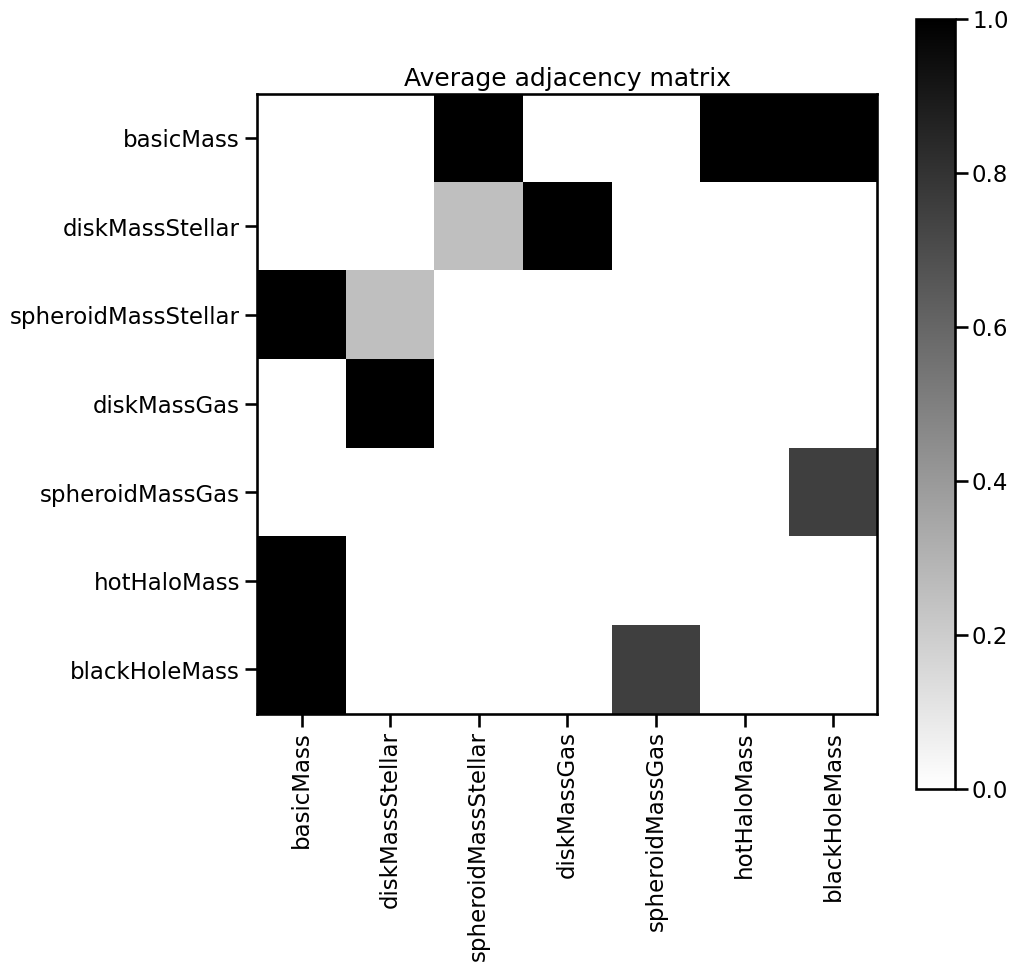

In [28]:
avg_adj_mat = np.mean(adj_mats, axis=0)
fig = plt.figure(figsize=(10, 10))
plt.imshow(avg_adj_mat, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.xticks(range(data.shape[1]), var_names, rotation=90)
plt.yticks(range(data.shape[1]), var_names)
plt.title('Average adjacency matrix')
plt.show()

> Observation: this adjacency matrix is quite different from all the previous ones generated (previous FGES and all PC-generated adjacency matrices). This could be due to FGES not having enough data points to work with in each subsample.

In [29]:
# 2 subsamples with 730 samples each - STILL SEEDED w/ 42
np.random.seed(42)
n_samples = 730

adj_mats = []
subsamples = subsample_data(data, n_samples)
for subsample in subsamples:
    edges, fges_result = infer_edges(subsample)
    adj_mats.append(fges_edges_to_mat(edges, data.shape[1]))

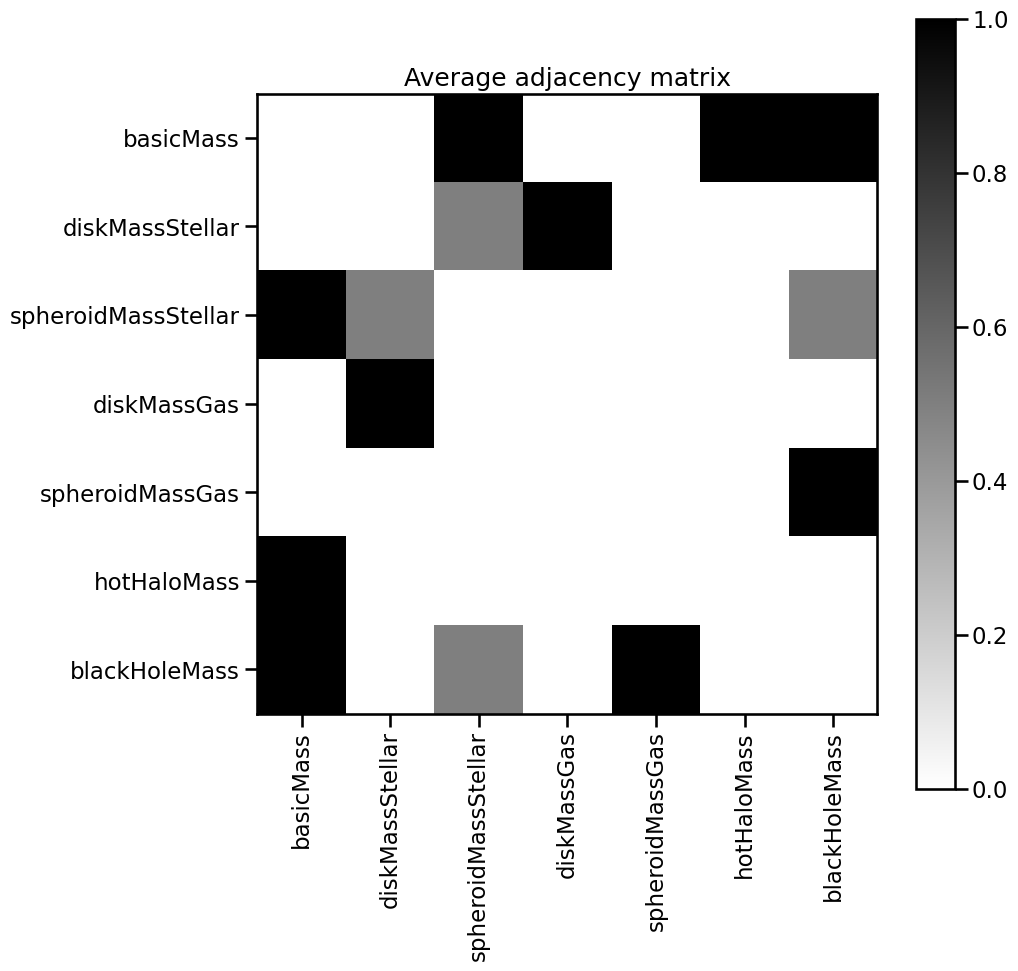

In [30]:
avg_adj_mat = np.mean(adj_mats, axis=0)
fig = plt.figure(figsize=(10, 10))
plt.imshow(avg_adj_mat, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.xticks(range(data.shape[1]), var_names, rotation=90)
plt.yticks(range(data.shape[1]), var_names)
plt.title('Average adjacency matrix')
plt.show()

> Using more data points lets us see that the more familiar graph is generated, FGES relies on having larger amounts of data

In [31]:
# 2 subsamples with 730 samples each - OVER 5 RANDOM SEEDS
adj_mats = []
for i in range(5):
    np.random.seed(i*8)
    
    subsamples = subsample_data(data, n_samples)
    for subsample in subsamples:
        edges, fges_result = infer_edges(subsample)
        adj_mats.append(fges_edges_to_mat(edges, data.shape[1]))

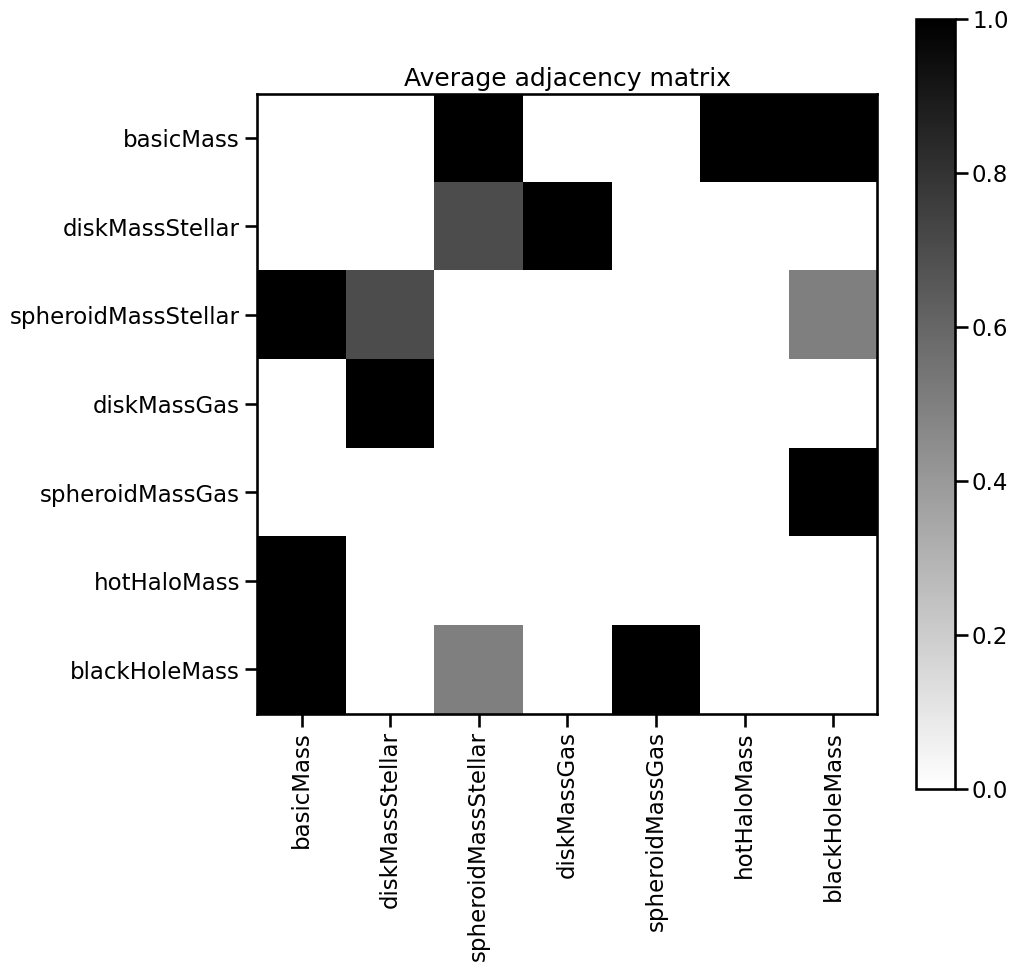

In [32]:
avg_adj_mat = np.mean(adj_mats, axis=0)
fig = plt.figure(figsize=(10, 10))
plt.imshow(avg_adj_mat, cmap='binary', interpolation='nearest')
plt.colorbar()
plt.xticks(range(data.shape[1]), var_names, rotation=90)
plt.yticks(range(data.shape[1]), var_names)
plt.title('Average adjacency matrix')
plt.show()

> Note: all graphs generated above use complexity/sparsity parameter = 8

> Observation: FGES graphs generally agree with the PC graphs thus far, they just have less certainty on two edges, may also be due to lack of data points

# Varying Complexity/Sparsity Parameter with Subsampling 

In [33]:
sparsity_params = [4, 6, 8, 10, 12, 14]
avg_adj_mats = []

for s in sparsity_params:
    adj_mats = []
    subsamples = subsample_data(data, n_samples)

    for subsample in subsamples:
        edges, fges_result = infer_edges(subsample, s=s)
        adj_mats.append(fges_edges_to_mat(edges, data.shape[1]))

    avg_adj_mats.append(np.mean(adj_mats, axis=0))

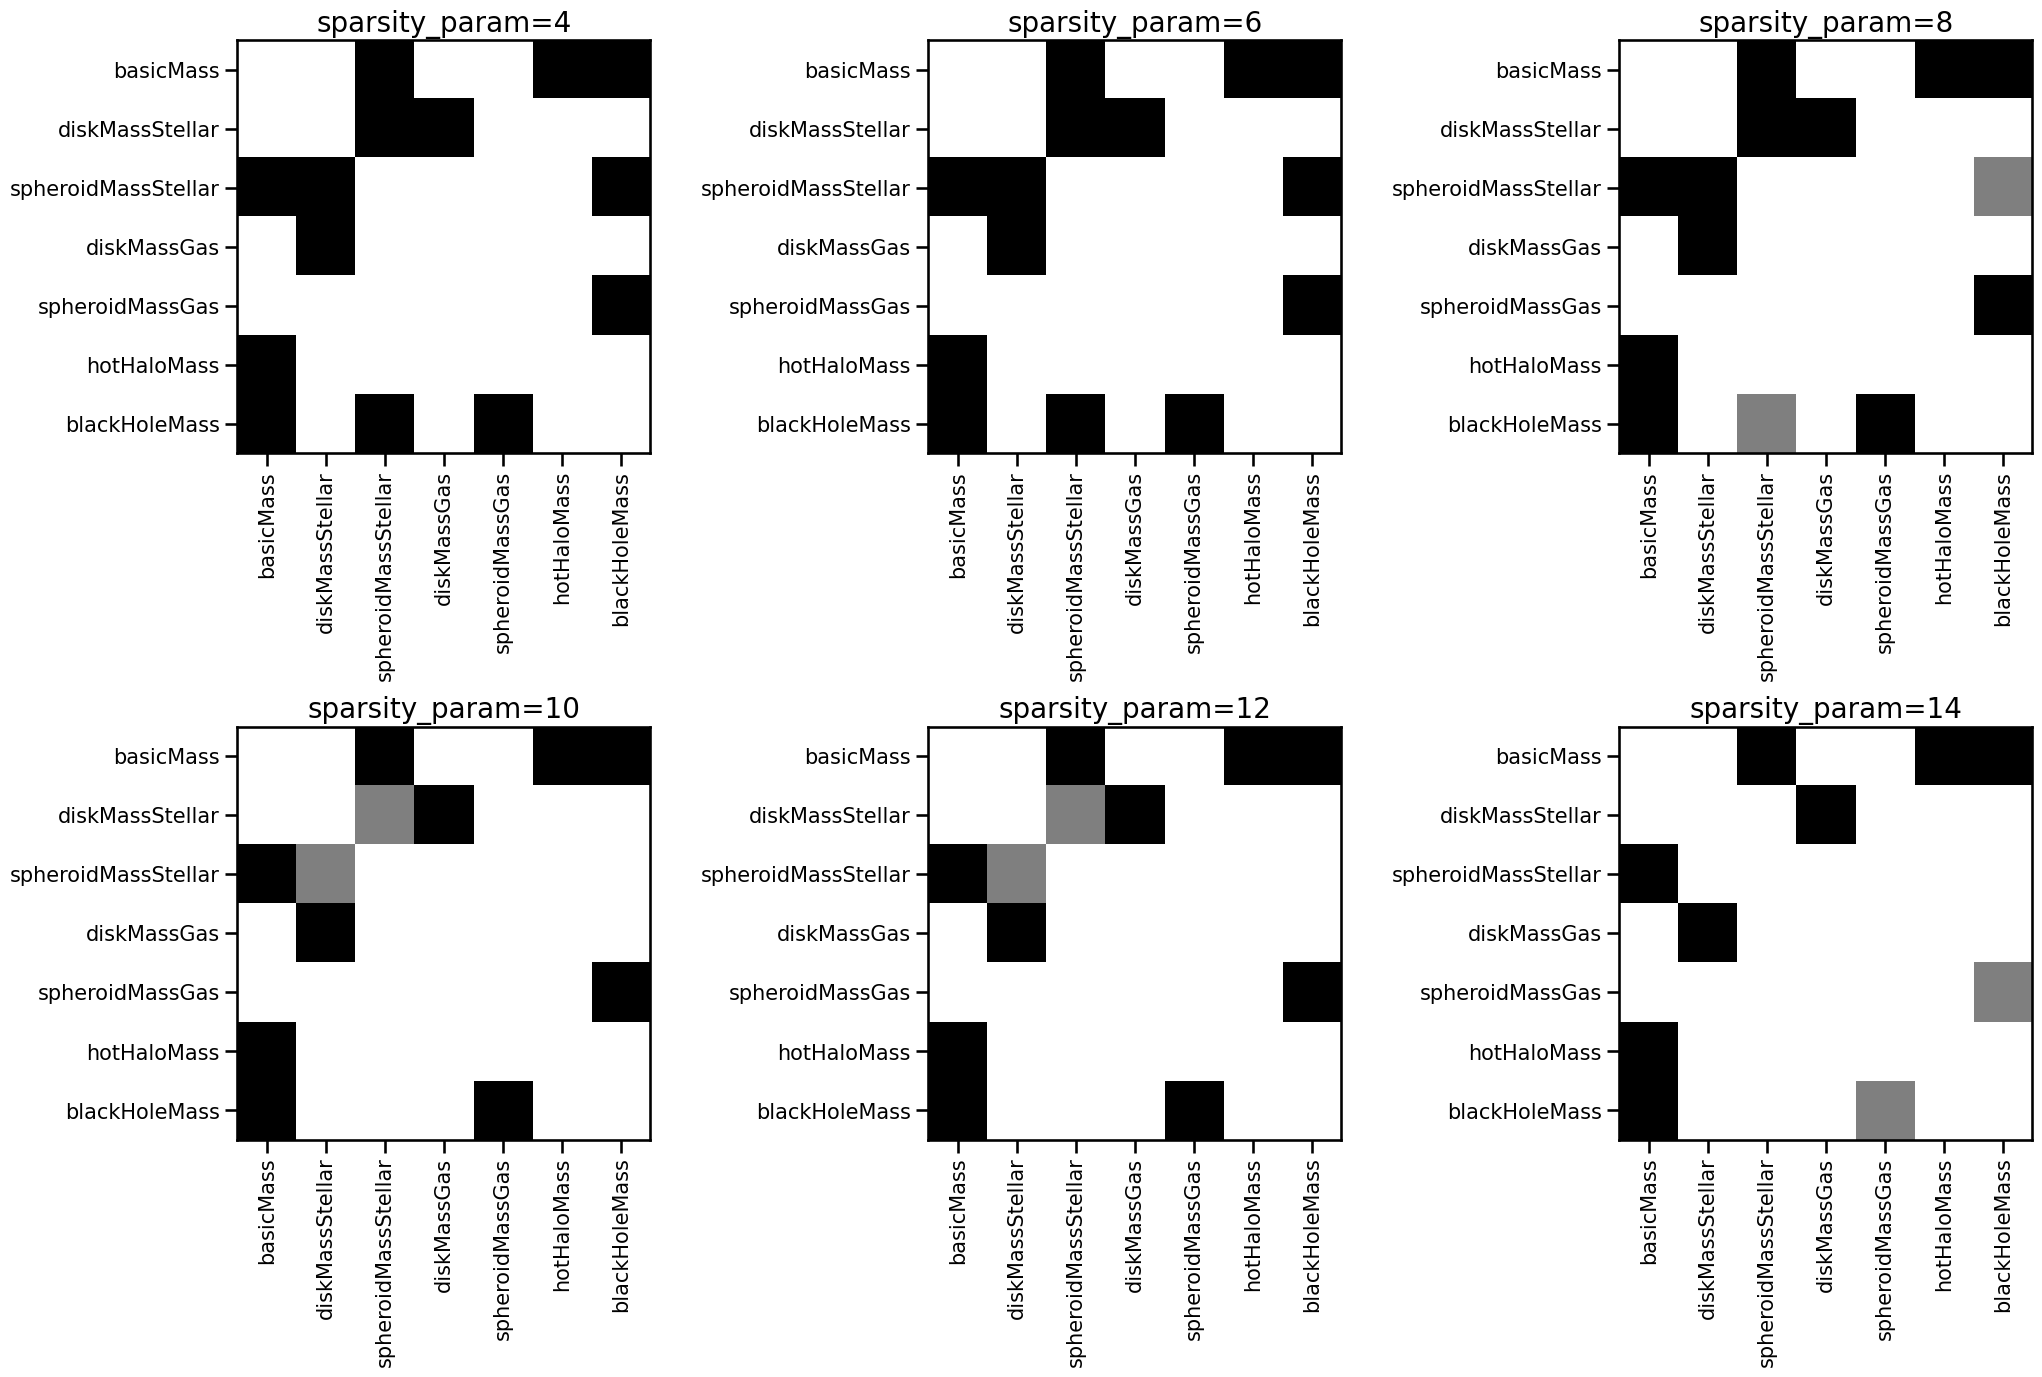

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(21,14))
for i, ax in enumerate(axs.flat):
    ax.imshow(avg_adj_mats[i], cmap='binary', interpolation='nearest')
    ax.set_xticks(range(7))
    ax.set_yticks(range(7))
    ax.set_xticklabels(var_names, rotation=90, fontsize=15)
    ax.set_yticklabels(var_names, fontsize=15)
    ax.set_title(f'sparsity_param={sparsity_params[i]}', fontsize=20)
plt.tight_layout()

> Observation: there are 4 or 5 edges we can be very certain about, two edges (diskMassStellar/spheroidMassStellar and spheroidMassStellar/blackHoleMass edges) seem to disappear as we increase the sparsity parameter. Greater sparsity -> less edges -> more important edges are present

# Varying Complexity/Sparsity Parameter with Repeated Subsampling

> This is being done because in the above set of graphs, each graph was generated with only 2 subsamples

In [35]:
sparsity_params = [4, 6, 8, 10, 12, 14]
avg_adj_mats = []

for s in sparsity_params:
    adj_mats = []

    for i in range(3):
        subsamples = subsample_data(data, n_samples)

        for subsample in subsamples:
            edges, fges_result = infer_edges(subsample, s=s)
            adj_mats.append(fges_edges_to_mat(edges, data.shape[1]))

    avg_adj_mats.append(np.mean(adj_mats, axis=0))

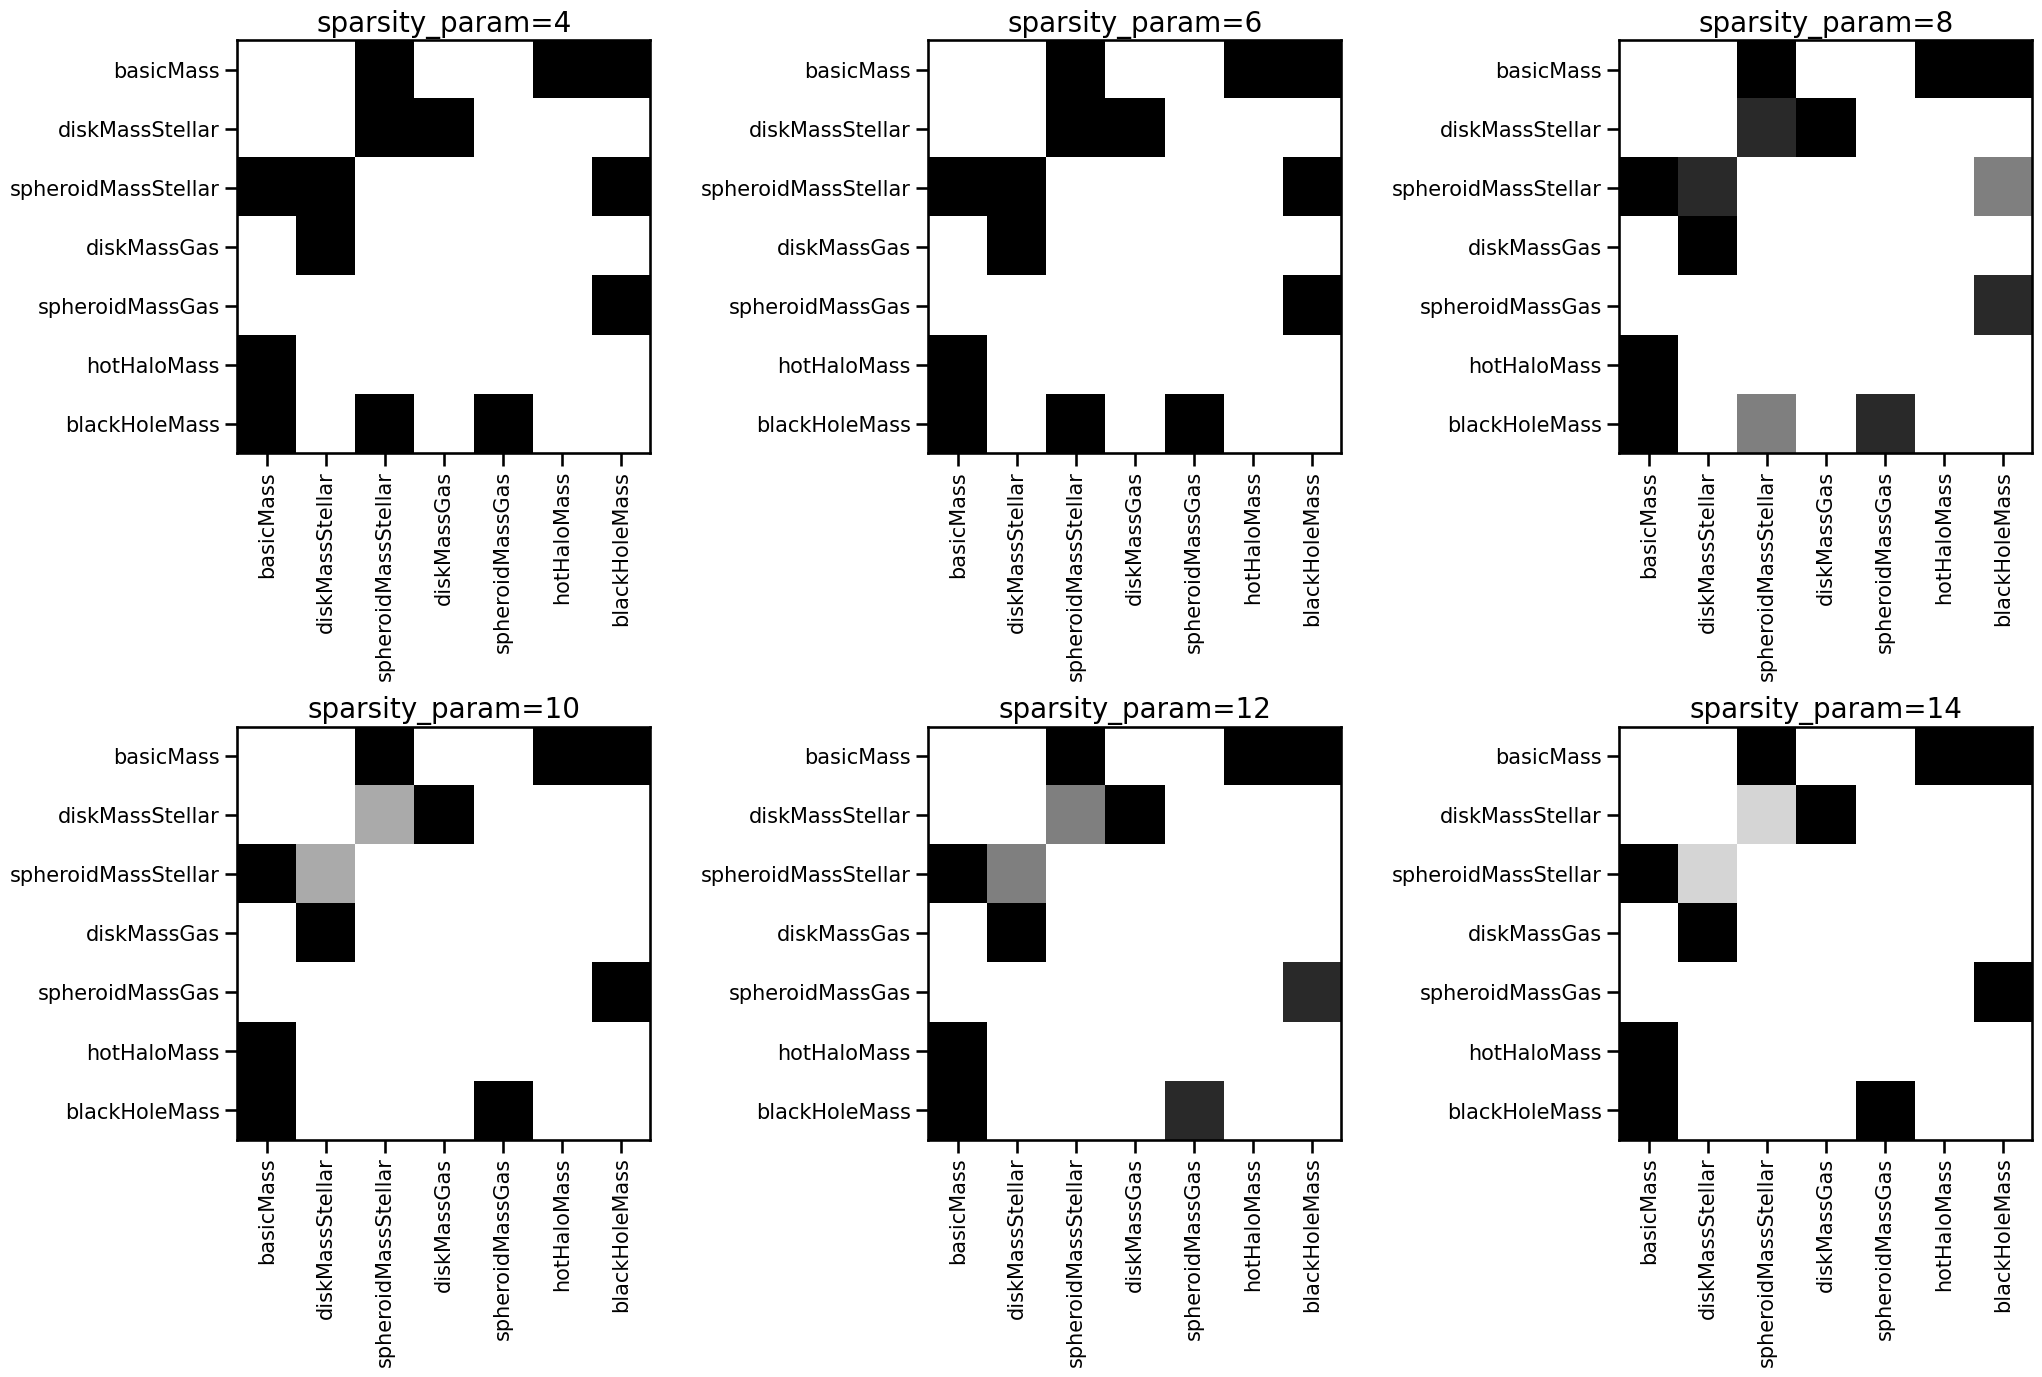

In [36]:
fig, axs = plt.subplots(2, 3, figsize=(21,14))
for i, ax in enumerate(axs.flat):
    ax.imshow(avg_adj_mats[i], cmap='binary', interpolation='nearest')
    ax.set_xticks(range(7))
    ax.set_yticks(range(7))
    ax.set_xticklabels(var_names, rotation=90, fontsize=15)
    ax.set_yticklabels(var_names, fontsize=15)
    ax.set_title(f'sparsity_param={sparsity_params[i]}', fontsize=20)
plt.tight_layout()

> Observation: we have the same trend as the previous set of graphs